In [1]:
%pylab inline

from itertools import product
from PyTools import err, nbins, binned_stat
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
write_tables_for_fig4 = False

def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"])
                               for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

def deg(t, m, p0):
    t0, Z0 = p0
    return m*array(t) + (Z0-m*t0)

def last(nbin, span):
    return span[0], span[-1]+diff(span)/nbin

def binner(x, y, bins=None, range=None, mu_stat="mean"):
    if bins==None: bins = 10
    if range==None:
        mn, mx = x.min(), x.max()
    else:
        mn, mx = range

    ind = lexsort((y, x))
    xs, ys = x[ind], y[ind]

    xedges = linspace(mn, mx, bins+1)
    i_bins = digitize(xs, xedges[:-1])
    
    x_cen = (xedges[:-1]+xedges[1:]) * 0.5
    if mu_stat=="mean":
        y_sta = array([mean(ys[i_bins==i]) for i in xrange(1, xedges.size)])
        
        myer = array([std(ys[i_bins==i]) for i in xrange(1, xedges.size)])
        y_dev = array([myer, myer])
    elif mu_stat=="median":
        y_sta = array([percentile(ys[i_bins==i], 50) for i in xrange(1, xedges.size)])

        myer = abs(array([percentile(ys[i_bins==i], 16) for i in xrange(1, xedges.size)]) - y_sta)
        pyer = abs(array([percentile(ys[i_bins==i], 84) for i in xrange(1, xedges.size)]) - y_sta)
        y_dev = array([myer, pyer])
    else:
        raise ValueError("Invalid value for 'mu_stat'.")

    return x_cen, y_sta, y_dev

def redux_histogram2d(xbins, ybins, X, Y, Z, stat=average, fill=None):
    reduced_Z = zeros([xbins.size-1,ybins.size-1])
    for i, j in product(range(xbins.size-1), range(ybins.size-1)):
        mask = ((xbins[i]<X)&(X<=xbins[i+1]))&((ybins[j]<Y)&(Y<=ybins[j+1]))
        reduced_Z[i,j] = stat(Z[mask]) if mask.sum()>0 else np.nan
    if fill!=None: reduced_Z[isnan(reduced_Z)]=fill
    return reduced_Z

class MidpointNormalize(cm.colors.Normalize):
    # from http://matplotlib.org/devdocs/users/colormapnorms.html
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        cm.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return ma.masked_array(np.interp(value, x, y))

if "paper_style" in dir():
    mnorm = 1e9
    od = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper/")
    par_lbs = dict(
        M=r"$M_\star$",
        log_t_M=r"$\left<\log{t_\star}\right>_M$",
        log_t_L=r"$\left<\log{t_\star}\right>_L$",
        log_Z_M=r"$\left<\log{Z_\star/Z\odot}\right>_M$",
        log_Z_L=r"$\left<\log{Z_\star/Z\odot}\right>_L$",
        Av=r"$A_V$"
    )
    res_lbs = dict(
        M=r"$\Delta\log{M_\star}$",
        log_t_M=r"$\Delta\left<\log{t_\star}\right>_M$",
        log_t_L=r"$\Delta\left<\log{t_\star}\right>_L$",
        log_Z_M=r"$\Delta\left<\log{Z_\star}\right>_M$",
        log_Z_L=r"$\Delta\left<\log{Z_\star}\right>_L$",
        Av=r"$\Delta A_V$"
    )
    con_lbs = dict(
        M=r"$\delta\log{M_\star}$",
        log_t_M=r"$\delta\left<\log{t_\star}\right>_M$",
        log_t_L=r"$\delta\left<\log{t_\star}\right>_L$",
        log_Z_M=r"$\delta\left<\log{Z_\star}\right>_M$",
        log_Z_L=r"$\delta\left<\log{Z_\star}\right>_L$",
        Av=r"$\delta A_V$"
    )
    hatching = "/"*15
    gray = "0.3"
    ssag_cl = "0.2"
    sdss_cl = "#F6C141"
    sdss_sg = [sdss_cl, "#E8601C"]
    jpas_cl = "#90C987"
    jpas_sg = [jpas_cl, "#4EB265"]
    spec_cl = "#7BAFDE"
    spec_sg = [spec_cl, "#1965B0"]
    map_col = cm.Blues
else:
    mnorm = 1e8
    od = "img/"
    par_lbs = ["Mass (log/M$\odot$)", "Age (log/yr)", "Age (log/yr)", "Metallicity (log/Z$\odot$)",
               "Metallicity (log/Z$\odot$)", "Dust Extinction (mag)", "Redshift"]

In [3]:
#READ TABLES

emission_detections = loadtxt("../inputs/real_deal/jpas_residual_emission.txt", dtype=str)
Lfrac = put_FITS_names(genfromtxt("data/RealDeal/lumfrac.txt", dtype=None, names=True))
snr_spec = genfromtxt("data/RealDeal/snr_spec.txt", dtype=None, names=True)
snr_jpas = genfromtxt("data/RealDeal/snr_jpas.txt", dtype=None, names=True)
Cind = put_FITS_names(genfromtxt("data/RealDeal/conIndex_test.txt", dtype=None, names=True))
u_lib, g_lib, r_lib, i_lib, z_lib = loadtxt("../inputs/tta_cb13/ssag/set_catalog.txt", usecols=range(1,1+5), unpack=True)
catalog = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)
gal2005 = genfromtxt("data/RealDeal/gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])

outs = os.path.expandvars("$master/inputs/real_deal/outs")
change_name = lambda name, strip: "spSpec"+name.lstrip(strip).replace(".log", ".fit")

spec_ne = genfromtxt("{}/spec/dynbas_output.log".format(outs), dtype=None, names=True)
spec_ne["input_file"] = array([change_name(name, "dynbasfit_processed_SPEC_") for name in spec_ne["input_file"]])
spec_ne["M_mod"] = log10(spec_ne["M_mod"])

jpas_ne = genfromtxt("{}/nem_jpas/dynbas_output.log".format(outs), dtype=None, names=True)
jpas_ne["input_file"] = array([change_name(name, "dynbasfit_processed_nem_JPAS_") for name in jpas_ne["input_file"]])
jpas_ne["M_mod"] = log10(jpas_ne["M_mod"])
                                                           
parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])

obs_con = dict(
    M=jpas_ne["M_mod"]-spec_ne["M_mod"],
    log_t_M=jpas_ne["log_t_M_mod"]-spec_ne["log_t_M_mod"],
    log_t_L=jpas_ne["log_t_L_mod"]-spec_ne["log_t_L_mod"],
    log_Z_M=jpas_ne["log_Z_M_mod"]-spec_ne["log_Z_M_mod"],
    log_Z_L=jpas_ne["log_Z_L_mod"]-spec_ne["log_Z_L_mod"],
    Av=jpas_ne["Av_mod"]-spec_ne["Av_mod"]
)

In [4]:
NR = 20

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields]

jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

jpas_res = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict(
    M=jpas_tta["M_mod"]-spec_tta["M_mod"],
    log_t_M=jpas_tta["log_t_M_mod"]-spec_tta["log_t_M_mod"],
    log_t_L=jpas_tta["log_t_L_mod"]-spec_tta["log_t_L_mod"],
    log_Z_M=jpas_tta["log_Z_M_mod"]-spec_tta["log_Z_M_mod"],
    log_Z_L=jpas_tta["log_Z_L_mod"]-spec_tta["log_Z_L_mod"],
    Av=jpas_tta["Av_mod"]-spec_tta["Av_mod"]
)

In [5]:
#COMMON MASKS
in_spec_ne = array([galaxy in spec_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_jpas_ne = array([galaxy in jpas_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_gal2005 = array([galaxy in gal2005["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
g05_in_sam = array([galaxy in spec_ne["input_file"] for galaxy in gal2005["input_file"]], dtype=bool)
sam_in_g05 = array([galaxy in gal2005["input_file"] for galaxy in spec_ne["input_file"]], dtype=bool)
nem_detect = ~array([galaxy in emission_detections for galaxy in spec_ne["input_file"]], dtype=bool)

col = (catalog["u_mag"] - catalog["r_mag"])[in_spec_ne]

#SAMPLE DEFINITION MASKS
# mask for g05 subsamples
SF_hSNR_g05_mask = (sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]>15.0)
SF_hSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]>15.0)
Pa_hSNR_g05_mask = (sam_in_g05)&(col>=2.22)&(snr_spec["snr_wall"]>15.0)
# mask for cat subsamples
SF_lSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]<=15.0)
Pa_lSNR_m16_mask = (~sam_in_g05)&(col>=2.22)&(snr_spec["snr_wall"]<=15.0)

# mask for removing trash
clean = nem_detect&(snr_spec["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)

# masks for galaxies classification
sfgal = col<2.22
pagal = col>=2.22

#COMMON QUANTITIES
cat = catalog[in_spec_ne]
lfr = Lfrac[in_spec_ne]
con, rat = array([[row["petroR90_r"]/row["petroR50_r"], 3.0/row["petroR90_r"]] if row["petroR50_r"]!=0 and row["petroR90_r"]!=0 else [inf, inf] for row in Cind[in_spec_ne]]).T

print "tables match?", all(spec_ne["input_file"]==cat["input_file"])&all(cat["input_file"]==lfr["input_file"])&\
                       all(cat["input_file"]==Cind["input_file"][in_spec_ne])

#WRITE DISCREPANCY TABLES(?)
if write_tables_for_fig4:
    savetxt("data/PhotoNearAnalysis/ur_color.txt", col[clean])
    for i, field in enumerate(spec_ne.dtype.names):
        if i in [2,3,4,5,6,7]:
            savetxt("data/PhotoNearAnalysis/JPAS_{0}.txt".format(field), jpas_ne[clean][field])
            savetxt("data/PhotoNearAnalysis/SPEC_{0}.txt".format(field), spec_ne[clean][field])
    write_tables_for_fig4 = True
    print "tables written"

tables match? True


In [6]:
print "SF_hSNR_g05:", SF_hSNR_g05_mask.sum()
print "SF_hSNR_m16:", SF_hSNR_m16_mask.sum()
print "Pa_hSNR_g05:", Pa_hSNR_g05_mask.sum()
print "SF_lSNR_m16:", SF_lSNR_m16_mask.sum()
print "Pa_lSNR_m16:", Pa_lSNR_m16_mask.sum()
print
print "Total      :", SF_hSNR_g05_mask.sum()+SF_hSNR_m16_mask.sum()+Pa_hSNR_g05_mask.sum()+SF_lSNR_m16_mask.sum()+\
                      Pa_lSNR_m16_mask.sum()

SF_hSNR_g05: 3575
SF_hSNR_m16: 1719
Pa_hSNR_g05: 5887
SF_lSNR_m16: 1608
Pa_lSNR_m16: 144

Total      : 12933


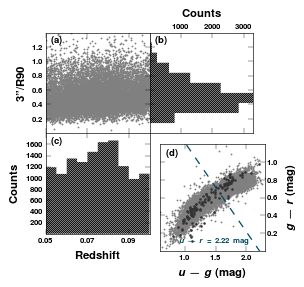

In [7]:
fig = figure(figsize=(2.5, 2.5))

gs1 = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, left=0, top=1)
ax00 = fig.add_subplot(gs1[0, 0], xticklabels=[])
ax01 = fig.add_subplot(gs1[0, 1])
ax10 = fig.add_subplot(gs1[1, 0])

ax01.tick_params(labelleft=False, labelbottom=False, labeltop=True)
ax01.xaxis.set_label_position("top")

gs2 = matplotlib.gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1, left=0, top=1, right=0.95, bottom=0.05)
ax11 = fig.add_subplot(gs2[1, 1])

ax11.tick_params(labelleft=False, labelright=True)
ax11.yaxis.set_label_position("right")

axs = array([[ax00, ax01], [ax10, ax11]])
# ---------------------------------------------------------------------------
axs[0,0].text(0.05, 0.90, r"\bf (a)", fontsize="small", ha="left", transform=axs[0,0].transAxes)
axs[0,0].set_xticks(arange(0.05, 0.11, 0.02))
axs[0,0].set_xlim(0.05, 0.1)
axs[0,0].set_ylim(0.00, 1.4)
axs[0,0].set_ylabel(r'\bf 3"/R90')
axs[0,0].scatter(cat["redshift"], rat, lw=0, c="0.5", s=2)
# ---------------------------------------------------------------------------
axs[0,1].text(0.05, 0.90, r"\bf (b)", fontsize="small", ha="left", transform=axs[0,1].transAxes)
axs[0,1].set_xticks([0, 1000, 2000, 3000, 3500])
rg = axs[0,1].set_ylim(0.00, 1.4)
axs[0,1].set_xlabel(r"\bf Counts")
axs[0,1].hist(rat, 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg,
               orientation="horizontal")
# ---------------------------------------------------------------------------
axs[1,0].text(0.05, 0.90, r"\bf (c)", fontsize="small", ha="left", transform=axs[1,0].transAxes)
axs[1,0].set_xticks(arange(0.05, 0.11, 0.02))
rg = axs[1,0].set_xlim(0.05, 0.1)
axs[1,0].set_xlabel(r'\bf Redshift')
axs[1,0].set_ylabel(r"\bf Counts")
axs[1,0].hist(cat["redshift"], 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg)
# ---------------------------------------------------------------------------
xl, yl = array(axs[1,1].set_xlim(0.6, 2.3)), array(axs[1,1].set_ylim(0.0, 1.2))
axs[1,1].text(0.05, 0.90, r"\bf (d)", fontsize="small", ha="left", transform=axs[1,1].transAxes)
axs[1,1].set_xlabel(r"\bf $u-g$ (mag)")
axs[1,1].set_ylabel(r"\bf $g-r$ (mag)")
axs[1,1].scatter(cat["u_mag"]-cat["g_mag"], cat["g_mag"]-cat["r_mag"], lw=0, c="0.5", s=2)
axs[1,1].scatter(u_lib-g_lib, g_lib-r_lib, lw=0, c="0.2", s=4)
axs[1,1].plot(xl, 2.22-xl, "--", color="#004E66")
axs[1,1].text(0.85, 0.08, r"\bf $u-r=2.22\,$mag", ha="right", fontsize="x-small", color="#004E66",
               transform=axs[1,1].transAxes)
# ---------------------------------------------------------------------------

for ax in axs.ravel():
    if not ax.is_first_col():
        ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(ax.get_yticks()[1:-1])

savefig("{}sample_chars".format(od))

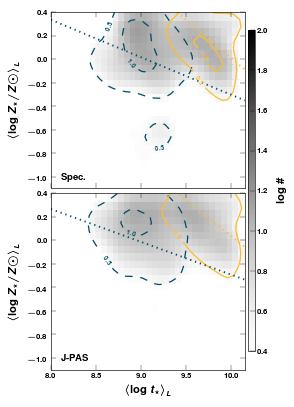

In [8]:
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 35, 25
tables = spec_tta, jpas_tta
N, bins = histogram(lcolor, 3, (1.3,3.0))
slopes = [[-0.32, -0.51, -0.65], [-0.28, -0.45, -0.61]]
sl_col = ["#004E66", "k", "#FCBE32"]
labels = r"\bf Spec.", r"\bf J-PAS"
x, y = "log_t_L_mod", "log_Z_L_mod"
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.0, 4.5))

ax1 = subplot2grid((20, 21), (0, 0), rowspan=10, colspan=20, ylabel=par_lbs[y.rstrip("_mod")], xticklabels=[], xlim=rx, ylim=ry)
ax2 = subplot2grid((20, 21), (10, 0), rowspan=10, colspan=20, xlabel=par_lbs[x.rstrip("_mod")], ylabel=par_lbs[y.rstrip("_mod")], xlim=rx, ylim=ry)
axc = subplot2grid((20, 21), (1, 20), rowspan=18)
axs = array([ax1, ax2])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in xrange(axs.size):
    axs[i].text(0.05, 0.05, labels[i], fontsize="small", ha="left", transform=axs[i].transAxes)

    H_al, xe, ye = histogram2d(tables[i][x], tables[i][y], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_al = gaussian_filter(H_al, sigma=1.5)
    H_al[H_al==0] = 1
    img = axs[i].pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.4, vmax=2.0, edgecolor="face")

    mask = lcolor<2.22
    H_sf, xe, ye = histogram2d(tables[i][x][mask], tables[i][y][mask], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_sf = gaussian_filter(H_sf, sigma=1.5)
    H_sf[H_sf==0] = 1
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_sf.T), [0.5,1,2], colors=sl_col[0], linewidths=1.0, linestyles="--")
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    mask = lcolor>=2.22
    H_pa, xe, ye = histogram2d(tables[i][x][mask], tables[i][y][mask], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_pa = gaussian_filter(H_pa, sigma=1.5)
    H_pa[H_pa==0] = 1
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_pa.T), [0.5,1,2], colors=sl_col[-1], linewidths=1.0)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    for ibin in xrange(bins.size-1):
        if ibin==1: continue
        if ibin<bins.size-2:
            bin_mask = (lcolor>=bins[ibin])&(lcolor<bins[ibin+1])
        else:
            bin_mask = (lcolor>=bins[ibin])&(lcolor<=bins[ibin+1])
        
        
        p0 = median(tables[i][x][bin_mask]), median(tables[i][y][bin_mask])
        axs[i].plot(rx, deg(rx, slopes[i][ibin], p0), ":", lw=1.5, color=sl_col[ibin])

cb = colorbar(img, cax=axc)
cb.set_label(r"\bf $\log{\#}$")

fig.savefig("{}{}".format("img/", "tta_AMR"))

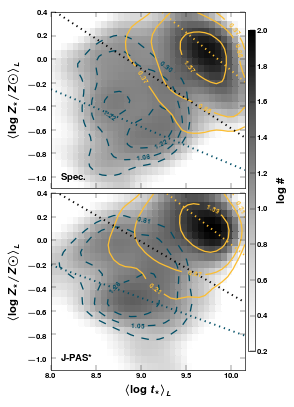

In [9]:
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 35, 25
tables = spec_ne, jpas_ne
N, bins = histogram(col[clean], 3, (1.3,3.0))
slopes = [[-0.32, -0.51, -0.65], [-0.28, -0.45, -0.61]]
sl_col = ["#004E66", "k", "#FCBE32"]
labels = r"\bf Spec.", r"\bf J-PAS*"
x, y = "log_t_L_mod", "log_Z_L_mod"
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.0, 4.5))

ax1 = subplot2grid((20, 21), (0, 0), rowspan=10, colspan=20, ylabel=par_lbs[y.rstrip("_mod")], xticklabels=[], xlim=rx, ylim=ry)
ax2 = subplot2grid((20, 21), (10, 0), rowspan=10, colspan=20, xlabel=par_lbs[x.rstrip("_mod")], ylabel=par_lbs[y.rstrip("_mod")], xlim=rx, ylim=ry)
axc = subplot2grid((20, 21), (1, 20), rowspan=18)
axs = array([ax1, ax2])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in xrange(axs.size):    
    axs[i].text(0.05, 0.05, labels[i], fontsize="small", ha="left", transform=axs[i].transAxes)

    H_al, xe, ye = histogram2d(tables[i][x][clean], tables[i][y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_al = gaussian_filter(H_al, sigma=1.5)
    H_al[H_al==0] = 1
    img = axs[i].pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.2, vmax=2.0, edgecolor="face")

    H_sf, xe, ye = histogram2d(tables[i][x][sfgal&clean], tables[i][y][sfgal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_sf = gaussian_filter(H_sf, sigma=1.5)
    H_sf[H_sf==0] = 1
    lv_sf = map(round, percentile(log10(H_sf), [68.0,80.0,95.0]), [2]*3)
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_sf.T), lv_sf, colors=sl_col[0], linewidths=1.0, linestyles="--")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

    H_pa, xe, ye = histogram2d(tables[i][x][pagal&clean], tables[i][y][pagal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    H_pa = gaussian_filter(H_pa, sigma=1.5)
    H_pa[H_pa==0] = 1
    lv_pa = map(round, percentile(log10(H_pa), [68.0,80.0,95.0]), [2]*3)
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_pa.T), lv_pa, colors=sl_col[-1], linewidths=1.0, linestyles="-")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

    for ibin in xrange(bins.size-1):
        if ibin<bins.size-2:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
        else:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
        
        
        p0 = median(tables[i][x][clean][bin_mask]), median(tables[i][y][clean][bin_mask])
        axs[i].plot(rx, deg(rx, slopes[i][ibin], p0), ":", lw=1.5, color=sl_col[ibin])

cb = colorbar(img, cax=axc)
cb.set_label(r"\bf $\log{\#}$")

savefig("{}{}".format("img/", "lw_AMR"))

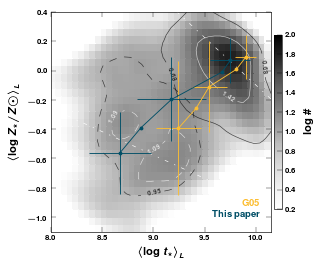

In [10]:
mask_m16 = clean&(sam_in_g05)
mask_g05 = clean[sam_in_g05]
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = spec_ne
N, bins = histogram(col[clean], 3, (1.3,3.0))
slopes = [-0.32, -0.51, -0.65]
sl_col = ["#004E66", "k", "#FCBE32"]
label = r"\bf Spec."
x, y = "log_t_L_mod", "log_Z_L_mod"
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 3))

ax = subplot2grid((10, 21), (0, 0), rowspan=10, colspan=20, xlabel=par_lbs[x.rstrip("_mod")], ylabel=par_lbs[y.rstrip("_mod")], xlim=rx, ylim=ry)
axc = subplot2grid((10, 21), (1, 20), rowspan=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_al = gaussian_filter(H_al, sigma=1.5)
H_al[H_al==0] = 1
img = ax.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.2, vmax=2.0, edgecolor="face")

H_sf, xe, ye = histogram2d(table[x][sfgal&clean], table[y][sfgal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_sf = gaussian_filter(H_sf, sigma=1.5)
H_sf[H_sf==0] = 1
lv_sf = map(round, percentile(log10(H_sf), [80.0,95.0]), [2]*2)
cont = ax.contour(xe[:-1], ye[:-1], log10(H_sf.T), lv_sf, cmap=cm.Greys_r, linewidths=0.5, linestyles="--", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

H_pa, xe, ye = histogram2d(table[x][pagal&clean], table[y][pagal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_pa = gaussian_filter(H_pa, sigma=1.5)
H_pa[H_pa==0] = 1
lv_pa = map(round, percentile(log10(H_pa), [80.0,95.0]), [2]*2)
cont = ax.contour(xe[:-1], ye[:-1], log10(H_pa.T), lv_pa, cmap=cm.Greys_r, linewidths=0.5, linestyles="-", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

cg05, tg05, tg05_rms = binner(col[mask_m16], gal2005[x][g05_in_sam][mask_g05], 5, (1.3,3.0), "mean")
cg05, Zg05, Zg05_rms = binner(col[mask_m16], gal2005[y][g05_in_sam][mask_g05], 5, (1.3,3.0), "mean")
cm16, tm16, tm16_rms = binner(col[mask_m16], table[x][mask_m16], 5, (1.3,3.0), "mean")
cm16, Zm16, Zm16_rms = binner(col[mask_m16], table[y][mask_m16], 5, (1.3,3.0), "mean")

ax.errorbar(tg05, Zg05, Zg05_rms, tg05_rms, "-o", sl_col[2], mew=0, ms=3, lw=0.7, color=sl_col[2], errorevery=2, zorder=99)
ax.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[0], mew=0, ms=3, lw=0.7, color=sl_col[0], errorevery=2, zorder=99)

for ibin in xrange(bins.size-1):
    if ibin==1: continue
    if ibin<bins.size-2:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
    else:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])

    p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
    ax.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color="w")

ax.text(0.95, 0.07, r"\bf This paper", color=sl_col[0], fontsize="small", ha="right", transform=ax.transAxes)
ax.text(0.95, 0.12, r"\bf G05", color=sl_col[2], fontsize="small", ha="right", transform=ax.transAxes)

cb = colorbar(img, cax=axc)
cb.set_label(r"\bf $\log{\#}$")

savefig("{}{}".format("img/", "spec_AMR"))

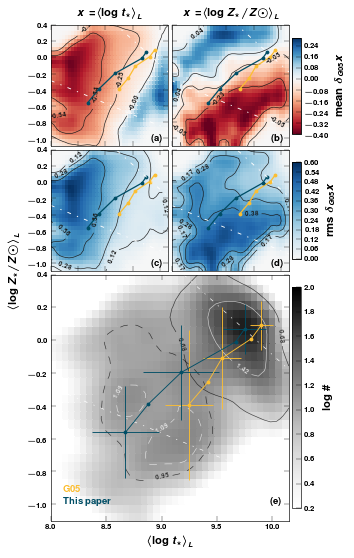

In [11]:
mask_m16 = clean&(sam_in_g05)
mask_g05 = clean[sam_in_g05]
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = spec_ne
N, bins = histogram(col[clean], 3, (1.3,3.0))
slopes = [-0.28, -0.45, -0.61]
sl_col = ["#004E66", "0.9", "#FCBE32"]
x, y = "log_t_L_mod", "log_Z_L_mod"
xr, yr = "log_t_L", "log_Z_L"
red_lb = xr, yr
red_st = mean, rms_flat
red_nm = "mean", "rms"
ab = ["a b".split(), "c d".split()]
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 6))

ax11 = subplot2grid((40, 21), (0, 0), rowspan=10, colspan=10, xticklabels=[], xlim=rx, ylim=ry)
ax21 = subplot2grid((40, 21), (10, 0), rowspan=10, colspan=10, xticklabels=[], xlim=rx, ylim=ry)
ax12 = subplot2grid((40, 21), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ax22 = subplot2grid((40, 21), (10, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)

axs = array([[ax11, ax12], [ax21, ax22]])
ax0 = subplot2grid((40, 21), (20, 0), rowspan=20, colspan=20, xlabel=par_lbs[xr], xlim=rx, ylim=ry)
ac1 = subplot2grid((40, 21), (1, 20), rowspan=8)
ac2 = subplot2grid((40, 21), (11, 20), rowspan=8)
acs = array([ac1, ac2])
ac0 = subplot2grid((40, 21), (21, 20), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#--------------------------------------------------------------------------------------------------------------------------
axs[1,0].set_ylabel(par_lbs[yr], y=0.0)

H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_al = gaussian_filter(H_al, sigma=1.5)
H_al[H_al==0] = 1
den = ax0.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.2, vmax=2.0, edgecolor="face")
cb0 = colorbar(den, cax=ac0)
cb0.set_label(r"\bf \log{\#}")

H_sf, xe, ye = histogram2d(table[x][sfgal&clean], table[y][sfgal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_sf = gaussian_filter(H_sf, sigma=1.5)
H_sf[H_sf==0] = 1
lv_sf = map(round, percentile(log10(H_sf), [80.0,95.0]), [2]*2)
cont = ax0.contour(xe[:-1], ye[:-1], log10(H_sf.T), lv_sf, cmap=cm.Greys_r, linewidths=0.5, linestyles="--", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

H_pa, xe, ye = histogram2d(table[x][pagal&clean], table[y][pagal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_pa = gaussian_filter(H_pa, sigma=1.5)
H_pa[H_pa==0] = 1
lv_pa = map(round, percentile(log10(H_pa), [80.0,95.0]), [2]*2)
cont = ax0.contour(xe[:-1], ye[:-1], log10(H_pa.T), lv_pa, cmap=cm.Greys_r, linewidths=0.5, linestyles="-", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

for ibin in xrange(bins.size-1):
    if ibin==1: continue
    if ibin<bins.size-2:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
    else:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
    p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
    ax0.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color="w")

cg05, tg05, tg05_rms = binner(col[mask_m16], gal2005[x][g05_in_sam][mask_g05], 5, (1.3,3.0), "mean")
cg05, Zg05, Zg05_rms = binner(col[mask_m16], gal2005[y][g05_in_sam][mask_g05], 5, (1.3,3.0), "mean")
cm16, tm16, tm16_rms = binner(col[mask_m16], table[x][mask_m16], 5, (1.3,3.0), "mean")
cm16, Zm16, Zm16_rms = binner(col[mask_m16], table[y][mask_m16], 5, (1.3,3.0), "mean")

ax0.errorbar(tg05, Zg05, Zg05_rms, tg05_rms, "-o", sl_col[2], mew=0, ms=3, lw=0.7, color=sl_col[2], errorevery=2, zorder=99)
ax0.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[0], mew=0, ms=3, lw=0.7, color=sl_col[0], errorevery=2, zorder=99)
ax0.text(0.05, 0.07, r"\bf This paper", color=sl_col[0], fontsize="small", ha="left", transform=ax0.transAxes)
ax0.text(0.05, 0.12, r"\bf G05", color=sl_col[2], fontsize="small", ha="left", transform=ax0.transAxes)
ax0.text(0.97, 0.07, r"\bf (e)", fontsize="small", ha="right", transform=ax0.transAxes)
#--------------------------------------------------------------------------------------------------------------------------
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    obs_con_g05 = table[[x,y][j]][mask_m16] - gal2005[[x,y][j]][g05_in_sam][mask_g05]
    
    if i==0: axs[i,j].set_title(r"\bf $x=${}".format(par_lbs[red_lb[j]]))
    
    H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    Z = redux_histogram2d(xe, ye, table[x][mask_m16], table[y][mask_m16], obs_con_g05, stat=red_st[i], fill=0.0)
    Z = gaussian_filter(Z, sigma=1.5)
    
    lv = map(round, percentile(Z, [25.0,50.0,75.0]), [2]*3)
    rz_i, rz_f = map(round, percentile(Z, [0.0,100.0]), [1]*2)

    red = axs[i,j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=cm.RdBu, vmin=rz_i, vmax=rz_f, norm=MidpointNormalize(midpoint=0.0), edgecolor="face")

    cb = colorbar(red, cax=acs[i])
    cb.set_label(r"\bf %s $\delta_{G05} x$"%(red_nm[i]))

    cont = axs[i,j].contour(xe[:-1], ye[:-1], Z.T, lv, colors="0.1", linewidths=0.5, linestyles="-")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

    axs[i,j].plot(tg05, Zg05, "-o", mew=0, ms=3, color=sl_col[2])
    axs[i,j].plot(tm16, Zm16, "-o", mew=0, ms=3, color=sl_col[0])
    
    axs[i,j].text(0.95, 0.05, r"\bf (%s)"%ab[i][j], fontsize="small", ha="right", transform=axs[i,j].transAxes)
    
    for ibin in xrange(bins.size-1):
        if ibin==1: continue
        if ibin<bins.size-2:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
        else:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
        p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
        axs[i,j].plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.7, color="w")

savefig("{}{}".format(od, "spec_AMR_con_maps"))

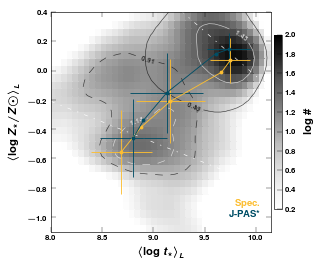

In [12]:
mmask = clean&(sam_in_g05)
gmask = clean[sam_in_g05]
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = jpas_ne
N, bins = histogram(col[clean], 3, (1.3,3.0))
slopes = [-0.28, -0.45, -0.61]
sl_col = ["#004E66", "k", "#FCBE32"]
label = r"\bf J-PAS*"
x, y = "log_t_L_mod", "log_Z_L_mod"
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 3))

ax = subplot2grid((10, 21), (0, 0), rowspan=10, colspan=20, xlabel=par_lbs[x.rstrip("_mod")], ylabel=par_lbs[y.rstrip("_mod")], xlim=rx, ylim=ry)
axc = subplot2grid((10, 21), (1, 20), rowspan=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_al = gaussian_filter(H_al, sigma=1.5)
H_al[H_al==0] = 1
img = ax.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.2, vmax=2.0, edgecolor="face")

H_sf, xe, ye = histogram2d(table[x][sfgal&clean], table[y][sfgal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_sf = gaussian_filter(H_sf, sigma=1.5)
H_sf[H_sf==0] = 1
lv_sf = map(round, percentile(log10(H_sf), [80.0,95.0]), [2]*2)
cont = ax.contour(xe[:-1], ye[:-1], log10(H_sf.T), lv_sf, cmap=cm.Greys_r, linewidths=0.5, linestyles="--", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

H_pa, xe, ye = histogram2d(table[x][pagal&clean], table[y][pagal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_pa = gaussian_filter(H_pa, sigma=1.5)
H_pa[H_pa==0] = 1
lv_pa = map(round, percentile(log10(H_pa), [80.0,95.0]), [2]*2)
cont = ax.contour(xe[:-1], ye[:-1], log10(H_pa.T), lv_pa, cmap=cm.Greys_r, linewidths=0.5, linestyles="-", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

cspec, tspec, tspec_rms = binner(col[clean], spec_ne[x][clean], 5, (1.3,3.0), "mean")
cspec, Zspec, Zspec_rms = binner(col[clean], spec_ne[y][clean], 5, (1.3,3.0), "mean")
cm16, tm16, tm16_rms = binner(col[clean], table[x][clean], 5, (1.3,3.0), "mean")
cm16, Zm16, Zm16_rms = binner(col[clean], table[y][clean], 5, (1.3,3.0), "mean")

ax.errorbar(tspec, Zspec, Zspec_rms, tspec_rms, "-o", sl_col[2], mew=0, ms=3, lw=0.7, color=sl_col[2], errorevery=2, zorder=99)
ax.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[0], mew=0, ms=3, lw=0.7, color=sl_col[0], errorevery=2, zorder=99)

for ibin in xrange(bins.size-1):
    if ibin==1: continue
    if ibin<bins.size-2:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
    else:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])

    p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
    ax.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color="w")

ax.text(0.95, 0.07, r"\bf J-PAS*", color=sl_col[0], fontsize="small", ha="right", transform=ax.transAxes)
ax.text(0.95, 0.12, r"\bf Spec.", color=sl_col[2], fontsize="small", ha="right", transform=ax.transAxes)

cb = colorbar(img, cax=axc)
cb.set_label(r"\bf $\log{\#}$")

savefig("{}{}".format("img/", "jpas_AMR"))

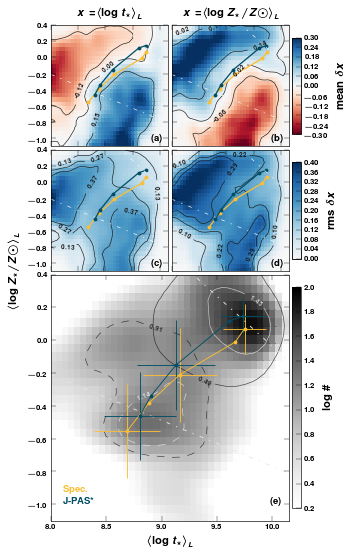

In [13]:
rx, ry= (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = jpas_ne
N, bins = histogram(col[clean], 3, (1.3,3.0))
slopes = [-0.28, -0.45, -0.61]
sl_col = ["#004E66", "0.9", "#FCBE32"]
x, y = "log_t_L_mod", "log_Z_L_mod"
xr, yr = "log_t_L", "log_Z_L"
red_lb = xr, yr
red_st = mean, rms_flat
red_nm = "mean", "rms"
ab = ["a b".split(), "c d".split()]
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 6))

ax11 = subplot2grid((40, 21), (0, 0), rowspan=10, colspan=10, xticklabels=[], xlim=rx, ylim=ry)
ax21 = subplot2grid((40, 21), (10, 0), rowspan=10, colspan=10, xticklabels=[], xlim=rx, ylim=ry)
ax12 = subplot2grid((40, 21), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ax22 = subplot2grid((40, 21), (10, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)

axs = array([[ax11, ax12], [ax21, ax22]])
ax0 = subplot2grid((40, 21), (20, 0), rowspan=20, colspan=20, xlabel=par_lbs[xr], xlim=rx, ylim=ry)
ac1 = subplot2grid((40, 21), (1, 20), rowspan=8)
ac2 = subplot2grid((40, 21), (11, 20), rowspan=8)
acs = array([ac1, ac2])
ac0 = subplot2grid((40, 21), (21, 20), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#--------------------------------------------------------------------------------------------------------------------------
axs[1,0].set_ylabel(par_lbs[yr], y=0.0)

H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_al = gaussian_filter(H_al, sigma=1.5)
H_al[H_al==0] = 1
den = ax0.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.2, vmax=2.0, edgecolor="face")
cb0 = colorbar(den, cax=ac0)
cb0.set_label(r"\bf \log{\#}")

H_sf, xe, ye = histogram2d(table[x][sfgal&clean], table[y][sfgal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_sf = gaussian_filter(H_sf, sigma=1.5)
H_sf[H_sf==0] = 1
lv_sf = map(round, percentile(log10(H_sf), [80.0,95.0]), [2]*2)
cont = ax0.contour(xe[:-1], ye[:-1], log10(H_sf.T), lv_sf, cmap=cm.Greys_r, linewidths=0.5, linestyles="--", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

H_pa, xe, ye = histogram2d(table[x][pagal&clean], table[y][pagal&clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_pa = gaussian_filter(H_pa, sigma=1.5)
H_pa[H_pa==0] = 1
lv_pa = map(round, percentile(log10(H_pa), [80.0,95.0]), [2]*2)
cont = ax0.contour(xe[:-1], ye[:-1], log10(H_pa.T), lv_pa, cmap=cm.Greys_r, linewidths=0.5, linestyles="-", alpha=0.7)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

for ibin in xrange(bins.size-1):
    if ibin==1: continue
    if ibin<bins.size-2:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
    else:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
    p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
    ax0.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.7, color="0.9")

cspec, tspec, tspec_rms = binner(col[clean], spec_ne[x][clean], 5, (1.3,3.0), "mean")
cspec, Zspec, Zspec_rms = binner(col[clean], spec_ne[y][clean], 5, (1.3,3.0), "mean")
cm16, tm16, tm16_rms = binner(col[clean], table[x][clean], 5, (1.3,3.0), "mean")
cm16, Zm16, Zm16_rms = binner(col[clean], table[y][clean], 5, (1.3,3.0), "mean")

ax0.errorbar(tspec, Zspec, Zspec_rms, tspec_rms, "-o", sl_col[2], mew=0, ms=3, lw=0.7, color=sl_col[2], errorevery=2, zorder=99)
ax0.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[0], mew=0, ms=3, lw=0.7, color=sl_col[0], errorevery=2, zorder=99)
ax0.text(0.05, 0.07, r"\bf J-PAS*", color=sl_col[0], fontsize="small", ha="left", transform=ax0.transAxes)
ax0.text(0.05, 0.12, r"\bf Spec.", color=sl_col[2], fontsize="small", ha="left", transform=ax0.transAxes)
ax0.text(0.97, 0.07, r"\bf (e)", fontsize="small", ha="right", transform=ax0.transAxes)
#--------------------------------------------------------------------------------------------------------------------------
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    if i==0: axs[i,j].set_title(r"\bf $x=${}".format(par_lbs[red_lb[j]]))
    
    H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    Z = redux_histogram2d(xe, ye, table[x][clean], table[y][clean], obs_con[red_lb[j]][clean], stat=red_st[i], fill=0.0)
    Z = gaussian_filter(Z, sigma=1.5)
    
    lv = map(round, percentile(Z, [25.0,50.0,75.0]), [2]*3)
    rz_i, rz_f = map(round, percentile(Z, [0.0,100.0]), [1]*2)

    red = axs[i,j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=cm.RdBu, vmin=rz_i, vmax=rz_f, norm=MidpointNormalize(midpoint=0.0), edgecolor="face")

    cb = colorbar(red, cax=acs[i])
    cb.set_label(r"\bf {} $\delta x$".format(red_nm[i]))
    
    cont = axs[i,j].contour(xe[:-1], ye[:-1], Z.T, lv, colors="0.1", linewidths=0.5, linestyles="-")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)
    
    axs[i,j].plot(tspec, Zspec, "-o", mew=0, ms=3, color=sl_col[2])
    axs[i,j].plot(tm16, Zm16, "-o", mew=0, ms=3, color=sl_col[0])

    axs[i,j].text(0.95, 0.05, r"\bf (%s)"%ab[i][j], fontsize="small", ha="right", transform=axs[i,j].transAxes)

    for ibin in xrange(bins.size-1):
        if ibin==1: continue
        if ibin<bins.size-2:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
        else:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
        p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
        axs[i,j].plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color="w")

savefig("{}{}".format(od, "jpas_AMR_con_maps"))

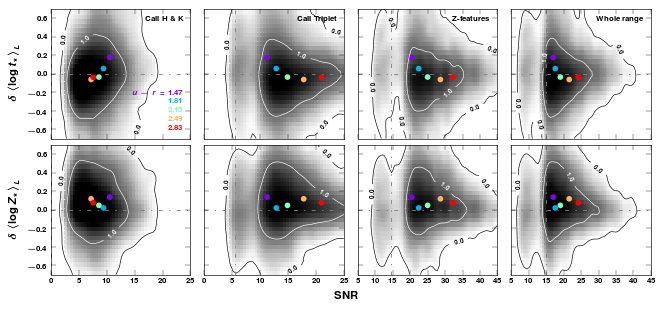

In [14]:
table = snr_spec
t_mask = snr_spec["snr_wall"]>=15.0
disc = obs_con
xs, ys = ("snr_CaHK", "snr_CaII", "snr_Zfea", "snr_wall"), ("log_t_L", "log_Z_L")
x_lbs = [r"\bf SNR", [r"\bf CaII H \& K", r"\bf CaII Triplet", r"\bf Z-features", r"\bf Whole range"]]
y_lbs = con_lbs[ys[0]], con_lbs[ys[1]]
nbins = (50, 30), (80, 30)
rxs, ry = ((0.0, 25.0), (5.0, 45.0)), (-0.7,+0.7)
#--------------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(2, 4, figsize=(7.0,3.3), sharex="col", sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)

ylim(ry)

for i, j in product(range(axs.shape[0]), range(axs.shape[1])):
    x, y = xs[j], ys[i]
    if j<=1:
        rx = rxs[0]
        nb = nbins[0]
    else:
        rx = rxs[1]
        nb = nbins[1]

    H, xe, ye = histogram2d(table[x][clean], disc[y][clean], nb, [last(nb[0],rx),last(nb[1],ry)])
    H = gaussian_filter(H, sigma=1.5)
    H[H==0] = 1
    den = axs[i,j].pcolormesh(xe[:-1], ye[:-1], log10(H.T), cmap=cm.Greys, vmin=0.0, vmax=1.5, edgecolor="face")
    cont = axs[i,j].contour(xe[:-1], ye[:-1], log10(H.T), [0.0,1.0], cmap=cm.Greys_r, linewidths=0.5)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    axs[i,j].axhline(ls="-.", color="0.5", lw=0.7)
    axs[i,j].axvline(min(table[x][clean&t_mask]), ls="-.", color="0.5", lw=0.7)

    ur_cen, bias_jpas, z = binner(lcolor, jpas_res[y], 5, (1.3,3.0), "median")
    ur_cen, bias_spec, z = binner(lcolor, spec_res[y], 5, (1.3,3.0), "median")
    bias_correction = bias_spec - bias_jpas

    ur_cen, d_mean, z = binner(col[clean], disc[y][clean], 5, (1.3,3.0), "mean")
    d_mean += bias_correction

    ur_cen, s_mean, z = binner(col[clean], table[x][clean], 5, (1.3,3.0), "mean")
    axs[i,j].scatter(s_mean, d_mean, c=ur_cen, s=20, lw=0, cmap=cm.rainbow)

    axs[i,j].set_xlim(rx)

    if j==0: axs[i,j].set_ylabel(y_lbs[i])
    if i==0: axs[i,j].text(0.95, 0.95, x_lbs[1][j], fontsize="x-small", va="top", ha="right", transform=axs[i,j].transAxes)

ur = [r"\bf $u-r=%.2f$"%ur_cen[i] if i==0 else r"\bf $%.2f$"%ur_cen[i] for i in xrange(ur_cen.size)]
cl = cm.rainbow(linspace(0,1,ur_cen.size))
for i in xrange(ur_cen.size):
    axs[0,0].text(0.95, 0.35-i*0.07, ur[i], color=cl[i], fontsize="x-small", ha="right", transform=axs[0,0].transAxes)

axs[1,2].set_xlabel(x_lbs[0], x=0, ha="right")

savefig("{}{}".format(od, "con_snr_maps_spec"))

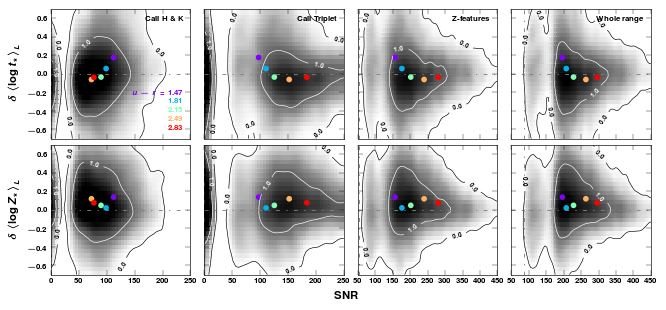

In [15]:
table = snr_jpas
t_mask = snr_jpas["snr_wall"]>=0.0
disc = obs_con
xs, ys = ("snr_CaHK", "snr_CaII", "snr_Zfea", "snr_wall"), ("log_t_L", "log_Z_L")
x_lbs = [r"\bf SNR", [r"\bf CaII H \& K", r"\bf CaII Triplet", r"\bf Z-features", r"\bf Whole range"]]
y_lbs = con_lbs[ys[0]], con_lbs[ys[1]]
nbins = (50, 30), (80, 30)
rxs, ry = ((0.0, 250.0), (50.0, 450.0)), (-0.7,+0.7)
#--------------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(2, 4, figsize=(7.0,3.3), sharex="col", sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)

ylim(ry)

for i, j in product(range(axs.shape[0]), range(axs.shape[1])):
    x, y = xs[j], ys[i]
    if j<=1:
        rx = rxs[0]
        nb = nbins[0]
    else:
        rx = rxs[1]
        nb = nbins[1]

    H, xe, ye = histogram2d(table[x][clean], disc[y][clean], nb, [last(nb[0],rx),last(nb[1],ry)])
    H = gaussian_filter(H, sigma=1.5)
    H[H==0] = 1
    den = axs[i,j].pcolormesh(xe[:-1], ye[:-1], log10(H.T), cmap=cm.Greys, vmin=0.0, vmax=1.5, edgecolor="face")
    cont = axs[i,j].contour(xe[:-1], ye[:-1], log10(H.T), [0.0,1.0], cmap=cm.Greys_r, linewidths=0.5)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    axs[i,j].axhline(ls="-.", color="0.5", lw=0.7)
    axs[i,j].axvline(min(table[x][clean&t_mask]), ls="-.", color="0.5", lw=0.7)

    ur_cen, bias_jpas, z = binner(lcolor, jpas_res[y], 5, (1.3,3.0), "median")
    ur_cen, bias_spec, z = binner(lcolor, spec_res[y], 5, (1.3,3.0), "median")
    bias_correction = bias_spec - bias_jpas

    ur_cen, d_mean, z = binner(col[clean], disc[y][clean], 5, (1.3,3.0), "mean")
    d_mean += bias_correction

    ur_cen, s_mean, z = binner(col[clean], table[x][clean], 5, (1.3,3.0), "mean")
    axs[i,j].scatter(s_mean, d_mean, c=ur_cen, s=20, lw=0, cmap=cm.rainbow)

    axs[i,j].set_xlim(rx)

    if j==0: axs[i,j].set_ylabel(y_lbs[i])
    if i==0: axs[i,j].text(0.95, 0.95, x_lbs[1][j], fontsize="x-small", va="top", ha="right", transform=axs[i,j].transAxes)

ur = [r"\bf $u-r=%.2f$"%ur_cen[i] if i==0 else r"\bf $%.2f$"%ur_cen[i] for i in xrange(ur_cen.size)]
cl = cm.rainbow(linspace(0,1,ur_cen.size))
for i in xrange(ur_cen.size):
    axs[0,0].text(0.95, 0.35-i*0.07, ur[i], color=cl[i], fontsize="x-small", ha="right", transform=axs[0,0].transAxes)

axs[1,2].set_xlabel(x_lbs[0], x=0, ha="right")

savefig("{}{}".format(od, "con_snr_maps_jpas"))